#UV treated Silk pattern decomposition
#Instead of using full 9 peaks, this script will instead use "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system
Author links open overlay panelMehtapFevziogluabOguz KaanOzturkbcBruce R.HamakerbcOsvaldo H.Campanellabd" and only analyze 4 "peaks"
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)

This notebook is bsed on a previously developed tool demonstrating how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition

Modified by Jeff
6.2.22: Need to apply FSD to spectra as I don't think this is being applied here before the least-squares fitting method




Setup, Import Code

In [12]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import sys
sys.path.append("../")
import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file


In [13]:
# import data file in csv format (modify for your file path and file name)
# Takes a csv file with first column being wavenumbers, 2nd and onward are relative intensity values, no heads
rawData_df = pd.read_csv(r"R:\Jeff\FTIR\Structural Mapping\Connor's Acoustic Film\8.15.22 US Films\US_Film_Control12.17.05 Monday Aug 15 2022.csv", header=None) 

In [14]:
dims = []
for i in range(1,rawData_df.shape[1]):
    dims.append(f"cols{i}")

In [15]:
column_names = list(['wavenumber'])+ dims
type(column_names[3])

str

In [16]:
beta_sheet_df = pd.DataFrame(rawData_df.values, columns = column_names)

## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.(Do we need to normalize to 1?)

In [17]:
# imports
%matplotlib inline

from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, four_peak  
from ftir.io.utils import create_df_from_single_file
import math
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.spatial import ConvexHull


In [18]:
#only show between 1715 and 1595
corrected_beta_sheet = []
for cols_ in beta_sheet_df.columns[1:]:
    #print(str(cols_))
    corrected_beta_sheet.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

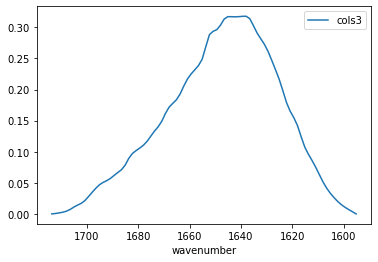

In [19]:
corrected_beta_sheet[2].plot.line(x='wavenumber', y=corrected_beta_sheet[2].columns[1]).invert_xaxis()

In [20]:
#this is in peak_fitting but I'm putting it here so peak libraries and other paramters like gain can be changed

reluncert = 5
gainnum = 0.90 #gain, was originally 0.95

# #from ftir.modeling.peak_definitions import hu_Kaplan_Cebe_2006_actual
# hu_Kaplan_Cebe_2006_rounded = {
#     'means': [1610, 1619, 1625, 1633,  1642, 1650, 1659, 1667, 1679, 1692, 1700],
#     'uncertainties': [(1605, 1615), (1616, 1621), (1622, 1627), (1628, 1637),
#                       (1638, 1646), (1647, 1655), (1656, 1662), (1663, 1670),
#                       (1671, 1685), (1686, 1696), (1697, 1703)],
#     'relative_uncertainties': [5, 2.5, 2.5, 4.5, 4, 4, 3, 3.5, 7, 5, 3],
#     'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate \u03B2-strand/\u03B2-sheet(weak)', 
#                     'intermolecular \u03B2-sheet (strong)', 'intramolecular \u03B2-sheet (strong)^b',
#                     'random coils/extended', 'random coils', '\u03B1-helices', 'turns',
#                     'turns', 'turns', 'intermolecular \u03B2_sheets (weak)']
# }

# six_peak = {
#     'means': [1610, 1625,  1646, 1659, 1679, 1700],
#     'uncertainties': [(1605, 1615), (1616, 1637),
#                       (1638, 1646), (1647, 1662), (1663, 1696), (1697, 1703)],
#     'relative_uncertainties': [5, 10.5, 4, 7.5, 16.5, 3],
#     'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate beta-strand/beta_sheet',
#                     'random coils', '\u03B1-helices', 'turns', 'intermolecular beta_sheets (weak)']
# }

# four_peak = {
#     'means': [1627,  1650, 1679,1700],
#     'uncertainties': [(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
#     #'relative_uncertainties': [10, 12, 16,3],
#     'relative_uncertainties': [2, 2, 1,2],
#     'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
#                     'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
# }

# five_peak = {
#     'means': [1610, 1627, 1650, 1679,1700],
#     'uncertainties': [(1605,1615),(1620, 1633), (1640, 1660), (1663, 1696), (1697, 1703)],
#     'relative_uncertainties': [5,5, 5, 5,5],
#     # 'uncertainties': [(1605,1615),(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
#     # 'relative_uncertainties': [5,5, 5, 5,5],
#     'assignments': ['side-chains', 'aggregate \u03B2-strand/\u03B2-sheet',
#                     'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
# }


# six_peakv2 = {
#     'means': [1610, 1627, 1646, 1659, 1679,1700],
#     'uncertainties': [(1605,1615),(1620, 1637), (1638,1655), (1656,1662), (1663, 1696), (1697, 1703)],
#     'relative_uncertainties': [reluncert,reluncert,reluncert,reluncert,reluncert,reluncert],
#     # 'uncertainties': [(1605,1615),(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
#     # 'relative_uncertainties': [5,5, 5, 5,5],
#     'assignments': ['side-chains', 'aggregate \u03B2-strand/\u03B2-sheet',
#                     'random coils', '\u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
# }


def gaussian_least_squares_(df, col, peaks,
                           peak_width, params=dict()): 
# peak width taken from: 
# "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"

    def fun(p, x, y):
        """ Minimizing across parameter space p, for a given range, x"""
        return gaussian_sum(x, *p) - y

    data = np.array(pd.concat([df.iloc[:,0], df[col]], axis=1))
    heights = guess_heights_(df, col, peaks['means'], gain=gainnum)
    width = peak_width
    lb = list()
    ub = list()
    guess = list()

    # Make 1-D array for optimization func definition above
    for mean, bound, height in zip(peaks['means'], peaks['uncertainties'],
                                   heights):
        lb.extend([0, bound[0], 0])
        ubh = np.inf if height <= 0 else height
        ub.extend([ubh, bound[1], peak_width*1])
        guess.extend([height*0.95, mean, peak_width])

    args = [fun, np.array(guess)]
    params['args'] = (data[:, 0], data[:, 1])
    params['bounds'] = (np.array(lb), np.array(ub))
    res = optimize.least_squares(*args, **params)

    areas = list()
    for i in range(0, len(res.x), 3):
        height = res.x[i]
        width = res.x[i+2]
        area = gaussian_integral(height, width)
        areas.append(area)
    return areas, res

def guess_heights_(df, col, center_list, gain=0.90):
    """ Determines guesses for the heights based on measured data.

    Function creates an integer mapping to the measured frequencies, and then
    creates an initial peak height guess of gain*actual height at x=freq*. A
    Default of 0.95 seems to work best for most spectra, but can be change to
    improve convergence.

    Parameters
    ----------
    df : Dataframe
        Dataframe containing the measured absorbance data

    col : string or integer
        Column index for the absorbance data being fit. Accepts either index
        or string convention.

    center_list : iterable of integers
        An iterable of integer peak positions used to find the experiment
        absorbance at a given wavenumber. I.e, the heights are returned at the
        center values in this iterable

    gain : number (optional)
        Fraction of the measured absorbance value to use determine the initial
        guess for the peak height. The value Default value is 0.95, and thus
        by default, all initial peak guesses are 95% of the peak max.

    """
    heights = []
    freq_map = {}
    for i in df.iloc[:,0]:
        j = math.floor(i)
        freq_map[j] = float(df[col].get(df.iloc[:,0] == i))
    print(freq_map)
    # pdb.set_trace()
    for i in center_list:
        height = freq_map[i]
        heights.append(gain*height)
    return heights

Plotting spectra and their invidual fits

In [21]:
# Jeff 6.14.2022 
# Make a simple input for x and y dimensions of mapping
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns xvalue and yvalue globally

import tkinter as tk
  
root=tk.Tk()
 
# setting the windows size
root.geometry("450x100")
root.eval('tk::PlaceWindow . center')
root.lift()

# declaring numerical variables for storing x and y values
x_var=tk.IntVar()
y_var=tk.IntVar()
   
# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, num_in_x,num_in_y
    num_in_x=int(x_var.get())
    num_in_y=int(y_var.get())
     
    print("Total number of spectra: " + str(num_in_x*num_in_y))
    root.destroy()
    
    
# creating a label for x using widget Label
x_label = tk.Label(root, text = 'Number of mapping points in x : ', font=('calibre',10, 'bold'))
  
# creating a entry for input of x using widget Entry
x_entry = tk.Entry(root,textvariable = x_var, font=('calibre',10,'normal'))
  
# creating a label for y
y_label = tk.Label(root, text = 'Number of mapping points in y : ', font = ('calibre',10,'bold'))
  
# creating a entry for y
y_entry=tk.Entry(root, textvariable = y_var, font = ('calibre',10,'normal'))
  
# creating a button using the widget button that will call the submit function
sub_btn=tk.Button(root,text = 'Submit', command=lambda: submit())
  
# placing the label and entry in the required position using grid method
x_label.grid(row=0,column=0)
x_entry.grid(row=0,column=1)
y_label.grid(row=1,column=0)
y_entry.grid(row=1,column=1)
sub_btn.grid(row=2,column=1)
  
# performing an infinite loop for the window to display
root.mainloop()

Total number of spectra: 9


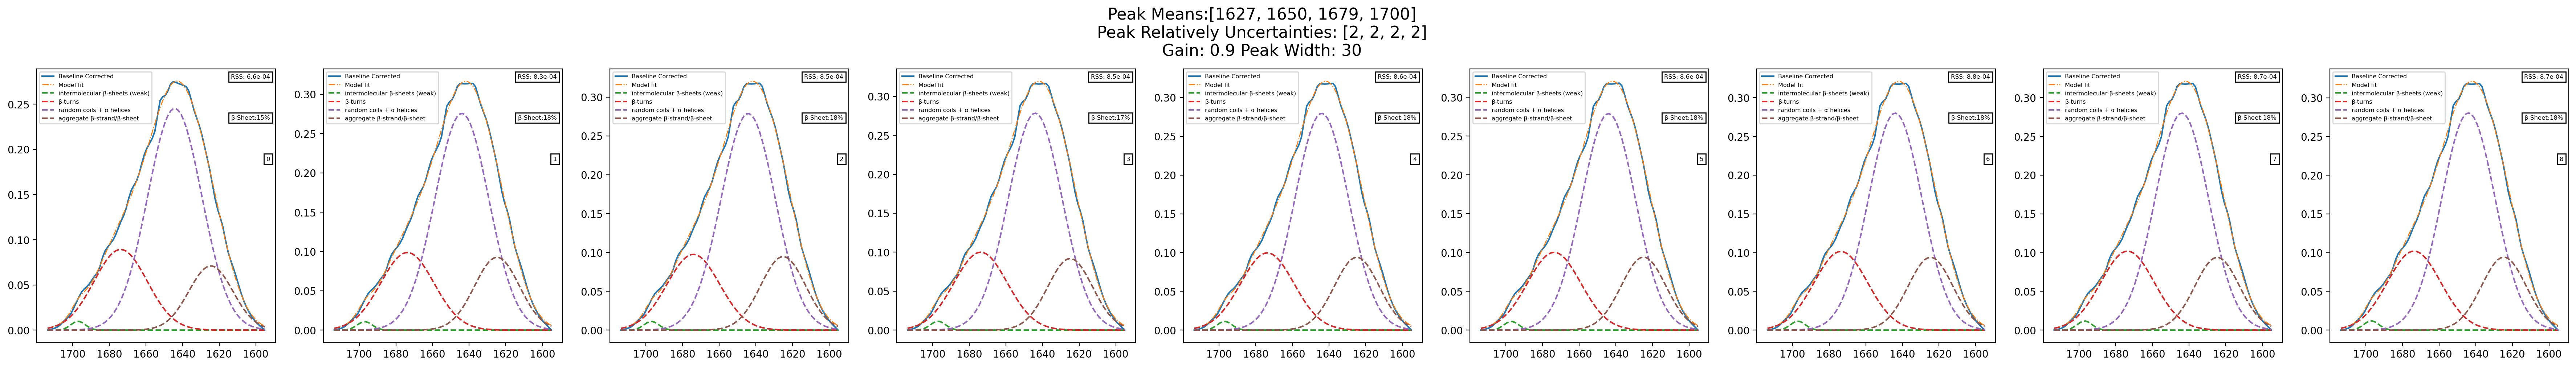

In [29]:
# 6/10/2022: attempt to use non-flattened indices so that I can more easily think about the math for propper placement of "pixels"; from above, the plots start at top left, but
# should actually start at bottom left. Need to confirm if the grid is started from another corner whether the FT-IR starts measuring from another corner, and then possibly put another gui to allow 
# users to select which corner data collection starts in
pw = 30 #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
peakfitlibname = 'four_peak'
peaksfittinglib = four_peak 

from matplotlib.offsetbox import AnchoredText

fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*5,num_in_y*5),dpi=200)
titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
    "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)

structs =[]
gaussian_data = []
for j in range(0,num_in_y):
    for i in range(0,num_in_x):     

        indexnum=(num_in_x)*(num_in_y-(j+1))+i #this should convert current index to the correct index from the original "linear" dataset since the data point table doesn't have any location information
        # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), that this doesn't require a different re-indexing operation
      
        sample = corrected_beta_sheet[(num_in_x)*(num_in_y-1-j)+i].columns[1]
        area, res = gaussian_least_squares(corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i], 
                                        corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i].columns[1], peak_width=pw, 
                                        peaks=peaksfittinglib, params={'loss':'linear'}) 
        structs.append(secondary_structure(area, peaksfittinglib))
        gaussian_list_data = gaussian_list(corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i]['wavenumber'], *res.x)
        gaussian_data.append(gaussian_list_data)
        
        #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
        xdata = corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i].iloc[:,0]
        y_fit = sum(gaussian_list_data)

        # index is a bit whack here, need to start from bottom left and starts from top left      
        # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
        if (num_in_y == 1) or (num_in_x == 1):
            axs[i].plot(xdata, corrected_beta_sheet[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
            axs[i].invert_xaxis()
            
            legend1 = axs[i].legend(loc="upper left",fontsize='xx-small')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
            ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
            axs[i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
                            bbox_transform=axs[i].transAxes)
            axs[i].add_artist(aRatioText)
            strindexnum= str(indexnum)
            numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[i].transAxes)
            axs[i].add_artist(numberinlist)        
        else:
            axs[j,i].plot(xdata, corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = corrected_beta_sheet[(num_in_x)*(num_in_y-(j+1))+i][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
            axs[j,i].invert_xaxis()
            
            legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
            ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
            axs[j,i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
                            bbox_transform=axs[j,i].transAxes)
            axs[j,i].add_artist(aRatioText)
            strindexnum= str(indexnum)
            numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[j,i].transAxes)
            axs[j,i].add_artist(numberinlist)
plt.show()

Compare % of beta sheet via Seaborn Heatmap

In [24]:
total_beta_percent = []
for i in range(0,len(structs)):
    total_beta_percent.append(structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])

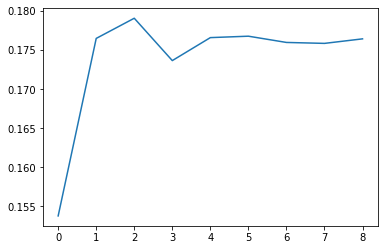

In [25]:
# 2D plot just in case it's useful
plt.plot(total_beta_percent)

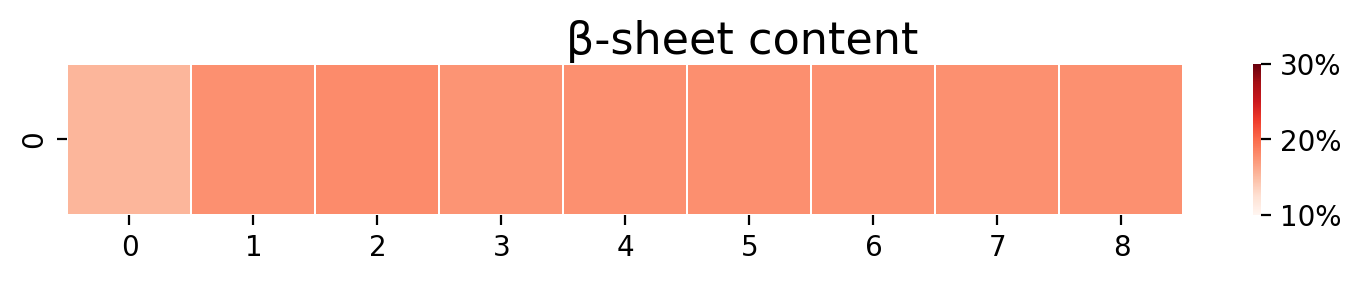

In [31]:
#heatmap via seaborn:
import seaborn as sns
plt.figure(figsize = (num_in_x,num_in_y),dpi=200)

#Split up points into x by y grid
break_total_beta_percent = np.array_split(np.array(total_beta_percent),num_in_y)

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=.1, vmax=0.3, linewidths=.05)
plt.suptitle(hmtitletext , fontsize=16,y=1.1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1,0.2,0.3])
cbar.set_ticklabels(['10%', '20%', '30%'])